In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from functools import partial
from field import cic_ma

In [83]:
@partial(jax.jit, static_argnums=(2, 3))
def linear(pos : jax.Array, weight : jax.Array, grid_size : int, dx : float) -> jax.Array:

    coords = jnp.linspace(start=0, stop=1, num=grid_size+1)

    grid = jnp.zeros((grid_size, grid_size, grid_size))

    # find position on the grid
    x_idx = jnp.digitize(pos[0], coords, right=True) - 1
    y_idx = jnp.digitize(pos[1], coords, right=True) - 1
    z_idx = jnp.digitize(pos[2], coords, right=True) - 1

    # assign the mass
    grid = grid.at[x_idx, y_idx, z_idx].set(weight / dx**3)

    return grid

In [7]:
def loss(params, grid_star : jax.Array, dx : float) -> jax.Array:
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
    grid = cic_ma(pos, weight, grid_size, dx)

    loss = jnp.mean((grid - grid_star)**2)
    return loss

In [14]:
def optimize(params, grid_star : jax.Array, dx : float, n_steps : int) -> jax.Array:

    optimizer = optax.adam(1e-2)
    opt_state = optimizer.init(params)

    loss_grad = jax.grad(loss)

    @jax.jit
    def step(params, opt_state):
        grad = loss_grad(params, grid_star, dx)
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    
    for i in range(n_steps):
        params, opt_state = step(params, opt_state)
        print(loss(params, grid_star, dx))

    return params

In [18]:
N = 10000
grid_size = 10
dx = 0.1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
weight = jax.random.uniform(key_weight, (N,))

# assign particles 
grid_star = cic_ma(pos, weight, grid_size, dx)

print(grid_star.mean())

4986.8784


312568.44
274665.97
383866.72
330735.84
228745.64
163281.55
139852.52
135261.61
131944.03
122869.97
107302.56
89437.97
74283.54
62993.02
54853.258
48851.97
44002.402
39854.49
36334.027
33429.055
30677.24
27899.713
25284.285
22979.64
20961.533
18799.223
16454.33
14317.065
12572.209
11223.613
10190.647
9249.423
8345.682
7536.623
6816.8496
6287.5825
6012.871
5817.9736
5476.966
4835.952
3958.625
3148.5
2632.768
2417.663
2410.5173
2441.3186
2306.0894
1955.6836
1577.0918
1386.234
1385.587
1409.1578
1332.2346
1146.3993
902.13763
698.7038
618.34296
626.86145
630.50037
586.19147
517.87286
462.24478
433.91867
409.35138
363.6426
305.652
255.04251
221.70045
202.78345
194.08253
187.14513
169.14633
148.58986
136.45103
129.42694
119.575836
102.39754
86.06663
75.64718
69.08943
62.653168
56.05169
52.332714
49.744698
46.522427
42.80318
38.1398
32.575104
27.730793
25.060936
23.318552
20.594212
17.914465
16.388285
15.788743
15.274348
14.324827
12.685128
10.647744
9.067175


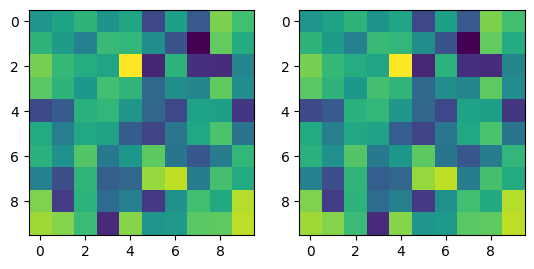

In [19]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

pos = jax.random.uniform(key_pos, (3, N)) 
weight = jax.random.uniform(key_weight, (N, ))

params_init = {
    'pos' : pos,
    'weight' : weight}


params = optimize(params_init, grid_star, dx, 100)

grid = cic_ma(params["pos"], params["weight"], grid_size, 0.1)

# plot side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(grid_star.sum(axis=0))
plt.subplot(1, 2, 2)
plt.imshow(grid.sum(axis=0))
plt.show()